In [66]:
# Import necessary components 
import math
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

In [67]:
# Import SARS and COVID csv files
# Only import 'date' and 'cumulative_cases' columns
canada_sars = pd.read_csv('./data/sars_canada.csv', header = 0, index_col = 0, usecols=['date', 'cumulative_cases'])
canada_covid = pd.read_csv('./data/covid_canada.csv', header = 0, index_col = 0, usecols=['date', 'cumulative_cases'])

# Given input data and how many training data it would be used,
# Split the input data into train and test data
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# Convert into data
data_train = canada_sars.values
data_test = canada_covid.values

# Combine training and test data
data = (data_train, data_test)

In [68]:
# Defining a few functions that is needed
def series_to_supervised(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    cols = list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        
    out = pd.concat(cols, axis=1)
    out.dropna(inplace=True)
    
    return out.values

def rmse(actual, predicted):
    print('Actual: ' + f'{actual[len(actual) - 1][0]}')
    print('Predicted: %.0f' % (predicted[len(predicted) - 1][0]))

    pyplot.plot(actual, label='Actual')
    pyplot.plot(predicted, label='Predicted')
    pyplot.legend()
    pyplot.show()
    
    return math.sqrt(mean_squared_error(actual, predicted))

def walk_forward_validation(data, config):
    predictions = list()
    
    train, test = data
    
    model = model_fit(train, config)
    
    history = [x for x in train]
    
    for i in range(len(test)):
        yhat = model_predict(model, history, config)
        predictions.append(yhat)
        history.append(test[i])
        
    error = rmse(test, predictions)
    print('Error: %.3f' % error)
    
    return error

def repeat_evaluate(data, config, n_repeats):
    scores = []
    for x in range(n_repeats):
        print(f'\nIteration: {x+1}')
        scores += [walk_forward_validation(data, config)]
    
    return scores

def summarize_scores(name, scores):
    scores_m, score_std = np.mean(scores), np.std(scores)
    print('\n%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    pyplot.boxplot(scores)
    pyplot.show()



Iteration: 1
Actual: 68848
Predicted: 60965


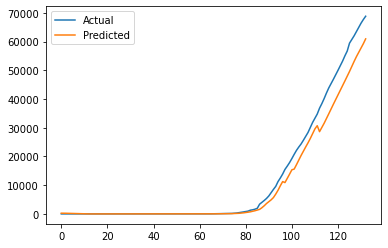

Error: 3799.235

Iteration: 2
Actual: 68848
Predicted: 64465


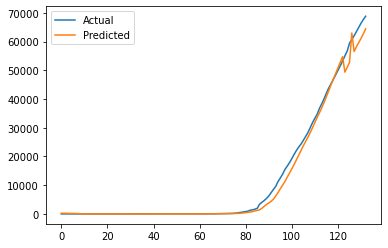

Error: 1929.899

Iteration: 3
Actual: 68848
Predicted: 65200


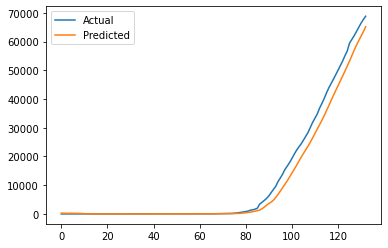

Error: 2914.733

Iteration: 4
Actual: 68848
Predicted: 74089


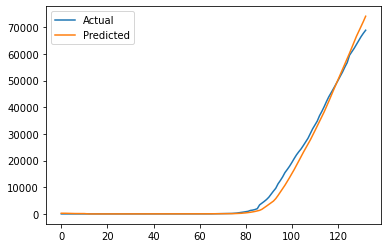

Error: 1764.228

Iteration: 5
Actual: 68848
Predicted: 65142


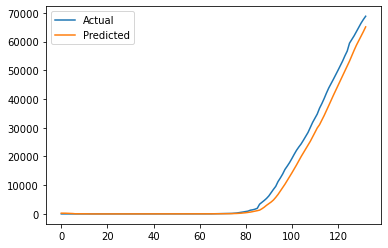

Error: 2857.739

Iteration: 6
Actual: 68848
Predicted: 75065


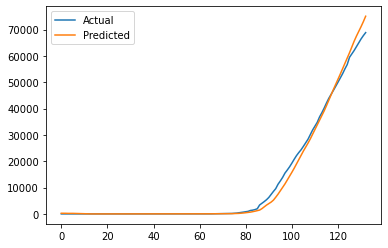

Error: 1671.423

Iteration: 7
Actual: 68848
Predicted: 74324


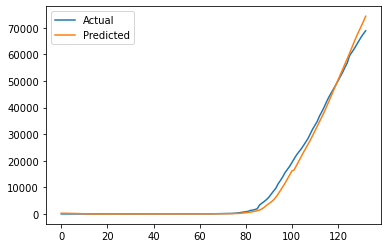

Error: 1658.934

Iteration: 8
Actual: 68848
Predicted: 63315


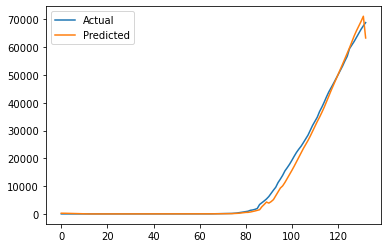

Error: 1487.082

Iteration: 9
Actual: 68848
Predicted: 73056


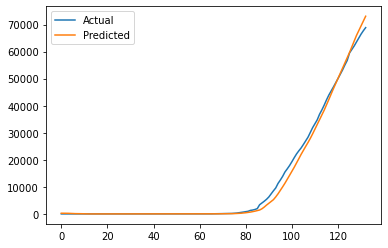

Error: 1509.640

Iteration: 10
Actual: 68848
Predicted: 68346


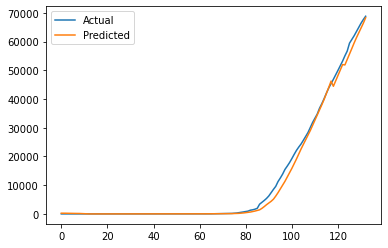

Error: 1442.597

CNN-LSTM: 2103.551 RMSE (+/- 761.676)


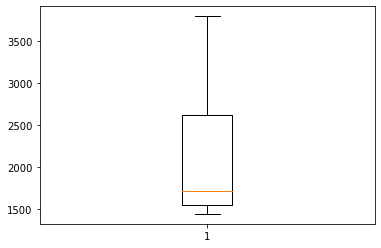

In [69]:
# Building the Convolutional Neural Network LSTM Model using the following configuration
# n_seq: The number of subsequences within a sample.
# n_steps: The number of time steps within each subsequence.
# n_filters: The number of parallel filters.
# n_kernel: The number of time steps considered in each read of the input sequence.
# n_nodes: The number of LSTM units to use in the hidden layer.
# n_epochs: The number of times to expose the model to the whole training dataset.
# n_batch: The number of samples within an epoch after which the weights are updated.

# Define and then fit the model
# Given the training data, and configuration, this function fits a model
def model_fit(train, config):
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    
    data = series_to_supervised(train, n_in=n_input)
    x, y = data[:, :-1], data[:, -1]
    x = x.reshape((x.shape[0], n_seq, n_steps, 1))
    
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(None, n_steps, 1))))
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    model.fit(x, y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    
    return model

# Predict the model
# Given a model, the history, and configuration, this function predicts a model
def model_predict(model, history, config):
    n_seq, n_steps, _, _, _, _, _= config
    n_input = n_seq * n_steps
    
    x_input = np.array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
    
    yhat = model.predict(x_input, verbose=0)
    
    return yhat[0]

# After defining the two functions needed to fit and predict the model, define the configuration
config = [2, 6, 256, 3, 100, 100, 100]

# Create and fit model
# Error is calculate throughout the entire prediction period
cases_scores = repeat_evaluate(data, config, 10)
summarize_scores('CNN-LSTM', cases_scores)